loading data
(88, 88)
(585, 585)
Data loaded
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1_con1 (Conv2D)        (None, 1, 337, 64)        1088      
                                                                 
 dropout_2 (Dropout)         (None, 1, 337, 64)        0         
                                                                 
 layer1_pool (MaxPooling2D)  (None, 1, 169, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 10816)             0         
                                                                 
 Dense-2 (Dense)             (None, 128)               1384576   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 

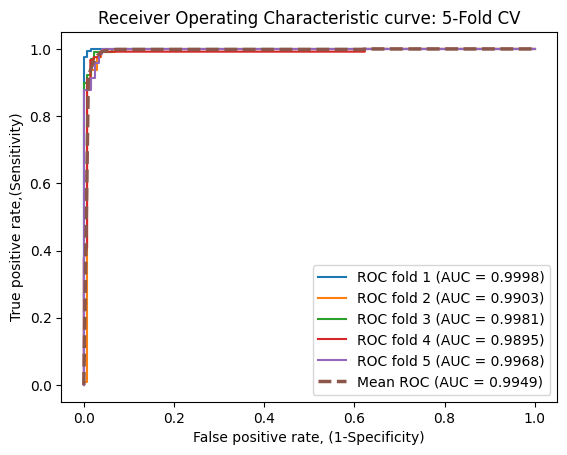

In [2]:
import numpy as np
import os
from matplotlib import pyplot
from numpy import interp
import sklearn
import tensorflow
import xlsxwriter 
import xlrd
from sklearn import svm #, grid_search
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import gzip
import pandas as pd
from random import randint
import scipy.io
from keras.layers import Input, Dense
from keras.engine.training import Model
from keras.models import Sequential, model_from_config,Model
from keras.layers.core import  Dropout, Activation, Flatten
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import PReLU
from keras.layers import PReLU
from keras.utils import np_utils, generic_utils
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam
from keras.layers import normalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Convolution1D, MaxPooling1D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMClassifier
from deepforest import main
import warnings
def normalize_features(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)
def prepare_data(seperate=False):
    print ("loading data")       
   
   
   
    disease_fea = np.loadtxt("E:\MAJOR-PROJECT-23\AE-RF-main\AE-RF\integrated Disease Similarity.txt",dtype=float,delimiter=",")
    circRNA_fea  = np.loadtxt("E:\MAJOR-PROJECT-23\AE-RF-main\AE-RF\integrated CircRNA  Similarity.txt",dtype=float,delimiter=",")
    interaction = np.loadtxt("E:\MAJOR-PROJECT-23\AE-RF-main\AE-RF\Association matrix.txt",dtype=int,delimiter=",")
    #apply normalization 
    disease_fea_norm = normalize_features(disease_fea)
    circRNA_fea_norm = normalize_features(circRNA_fea)
    
    a=disease_fea_norm.shape      
    print(a)
    b=circRNA_fea_norm.shape
    print(b)
    link_number = 0
    train = []  
    testfnl= []       
    label1 = []
    label2 = []
    label22=[]
    ttfnl=[]
    
    for i in range(0, interaction.shape[0]):   
        for j in range(0, interaction.shape[1]): 
           
            if interaction[i, j] == 1:                     
                label1.append(interaction[i,j])             
                link_number = link_number + 1              
                  
                circRNA_fea_tmp = list(circRNA_fea_norm[i]) 
                disease_fea_tmp = list(disease_fea_norm[j])
                tmp_fea = (circRNA_fea_tmp,disease_fea_tmp)   
                train.append(tmp_fea)                       
            elif interaction[i,j] == 0:                     
                label2.append(interaction[i,j])             
                  
                circRNA_fea_tmp1 = list(circRNA_fea_norm[i])		               
                disease_fea_tmp1 = list(disease_fea_norm[j])
                test_fea= (circRNA_fea_tmp1,disease_fea_tmp1) 
                testfnl.append(test_fea)                    
    
    print("Data loaded") 
    m = np.arange(len(label2))           
    
    np.random.shuffle(m)
    
    for x in m:
        ttfnl.append(testfnl[x])
        label22.append(label2[x])
   
           
    for x in range(0, link_number):        
        tfnl= ttfnl[x]                                    
        lab= label22[x]                                      
        
        train.append(tfnl)                                  
        label1.append(lab) 
    
    return np.array(train,dtype=object), label1, np.array(testfnl,dtype=object) 
def calculate_performace(test_num, pred_y,  labels):
    tp =0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] ==1:
            if labels[index] == pred_y[index]:
                tp = tp +1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn +1
            else:
                fp = fp + 1               
            
    acc = float(tp + tn)/test_num
    
    if tp == 0 and fp == 0:
        precision = 0
        MCC = 0
        f1_score=0
        sensitivity =  float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
    else:
        precision = float(tp)/(tp+ fp)
        sensitivity = float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
        MCC = float(tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
        f1_score= float(2*tp)/((2*tp)+fp+fn)

    return acc, precision, sensitivity, specificity, MCC,f1_score
def transfer_array_format(data):     
    formated_matrix1 = []
    formated_matrix2 = []
    
    for val in data:
        
        formated_matrix1.append(val[0])   
        formated_matrix2.append(val[1])   
           
    
    return np.array(formated_matrix1), np.array(formated_matrix2)
def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder
def CNN_feature(x,y):

   
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


    
   
    x_train=x_train.reshape(-1,1,673,1)
    x_test=x_test.reshape(-1,1,673,1)
    
    x = x.reshape(-1,1,673,1)    
    
    
    model = Sequential()
    return_sequences=True

    model.add(Convolution2D(64,(1,16), strides=(2,2), activation='relu', padding='same', data_format='channels_last',name='layer1_con1',input_shape=(1,673,1)))

    
    model.add(Dropout(0.5)) 

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding = 'same', data_format='channels_last',name = 'layer1_pool'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu',  name='Dense-2')) 
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid',))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    model.summary()
    
    import numpy as np
    x_train = np.array(x_train) #changing to numpy array
    y_train = np.array(y_train)#changin to numpy array
    
    model.fit(x_train, y_train, epochs=15, batch_size=10,validation_split=0.1)
    from keras.models import Model
    dense1_layer_model = Model(inputs=model.input, outputs=model.get_layer('Dense-2').output)
    dense1_output = dense1_layer_model.predict(x)

    print("extracted feature shape=dense1_output=",dense1_output.shape) # (1328,128)
   
    return dense1_output 
def DeepMDA():
    X, labels,T = prepare_data(seperate = True)     
      
    X_data1, X_data2 = transfer_array_format(X)    
           
    X_data1= np.concatenate((X_data1, X_data2 ), axis = 1)    
           
    y, encoder = preprocess_labels(labels)
    num = np.arange(len(y))   
    np.random.shuffle(num)
    X_data1 = X_data1[num]
    y = y[num]
    
    
  
    real__labels = []
    for val in y:
       if val[0] == 1:             
          real__labels.append(0)
       else:
          real__labels.append(1)

     
    
    
    t=0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    
            
    X_data1 = CNN_feature(X_data1,real__labels)
       
        
    
    num_cross_val = 5
    all_performance = []
    all_performance_ELDMA = []
    
    all_labels = []
    all_prob = {}
    
    all_prob[0] = []
    all_prob[1] = []
    all_prob[2] = []
    all_prob[3] = []
    all_averrage = []
    for fold in range(num_cross_val):
        train1 = np.array([x for i, x in enumerate(X_data1) if i % num_cross_val != fold])
        test1 = np.array([x for i, x in enumerate(X_data1) if i % num_cross_val == fold])
        train_label = np.array([x for i, x in enumerate(y) if i % num_cross_val != fold])
        test_label = np.array([x for i, x in enumerate(y) if i % num_cross_val == fold])
        
          
        real_labels = []
        for val in test_label:
            if val[0] == 1:             
                real_labels.append(0)
            else:
                real_labels.append(1)

        train_label_new = []
        for val in train_label:
            if val[0] == 1:
                train_label_new.append(0)
            else:
                train_label_new.append(1)
        class_index = 0        
                      
                            
        class_index = class_index + 1

        prefilter_train = train1
        prefilter_test = test1   
       
                
       #Random forest
        rf = RandomForestClassifier(n_estimators=100)
        
        
       # LightGBM
        params_1 = {'n_estimators':100,             # Number of boosting stages (trees)
                  'learning_rate': 0.1,             # Step size at each iteration
                  'max_depth': 3,'verbose': -1 }    # Maximum depth of individual trees
        
        lgbm = LGBMClassifier(**params_1,force_col_wise=True,verbose_eval=False)  

        
        
        #Catboost   
        params = {'learning_rate': 0.1, 'depth': 6,\
          'l2_leaf_reg': 3, 'iterations': 100}
  
        # Initialize the CatBoostClassifier object with the defined hyperparameters 
        clf = CatBoostClassifier(**params,verbose=0)
        
        #Voting Classifier
        
        voting_clf = VotingClassifier(estimators=[('lightgbm', lgbm), ('random-forest', rf), ('catboost', clf)], voting='soft')
        voting_clf.fit(prefilter_train, train_label_new)
        ae_y_pred_prob = voting_clf.predict_proba(prefilter_test)[:,1]
        
        proba = transfer_label_from_prob(ae_y_pred_prob)                
                                                                                                               
                       
        acc, precision, sensitivity, specificity, MCC, f1_score = calculate_performace(len(real_labels), proba,  real_labels)
      
        fpr, tpr, auc_thresholds = roc_curve(real_labels, ae_y_pred_prob)
        auc_score = auc(fpr, tpr)
        #scipy.io.savemat('ELDMA',{'fpr':fpr,'tpr':tpr,'auc_score':auc_score})


        precision1, recall, pr_threshods = precision_recall_curve(real_labels, ae_y_pred_prob)
        aupr_score = auc(recall, precision1)
        print ("ELDMA:",acc, precision, sensitivity, specificity, MCC, auc_score, aupr_score,f1_score)
        all_performance_ELDMA.append([acc, precision, sensitivity, specificity, MCC, auc_score, aupr_score,f1_score])
        t =t+1  #  AUC fold number
        
        pyplot.plot(fpr,tpr,label= 'ROC fold %d (AUC = %0.4f)' % (t, auc_score))
        mean_tpr += interp(mean_fpr, fpr, tpr) 
        mean_tpr[0] = 0.0
                
                    
        pyplot.xlabel('False positive rate, (1-Specificity)')
        pyplot.ylabel('True positive rate,(Sensitivity)')
        pyplot.title('Receiver Operating Characteristic curve: 5-Fold CV')
        pyplot.legend()
    
    mean_tpr /= num_cross_val
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)                 
    
               
    #print ('mean performance of rf using raw feature')
    print (np.mean(np.array(all_performance_ELDMA), axis=0))
    Mean_Result=[]
    Mean_Result= np.mean(np.array(all_performance_ELDMA), axis=0)
    print ('---' * 20)
    print('Mean-Accuracy=', Mean_Result[0],'\n Mean-precision=',Mean_Result[1])
    print('Mean-Sensitivity=', Mean_Result[2], '\n Mean-Specificity=',Mean_Result[3])
    print('Mean-MCC=', Mean_Result[4],'\n' 'Mean-auc_score=',Mean_Result[5])
    print('Mean-Aupr-score=', Mean_Result[6],'\n' 'Mean_F1=',Mean_Result[7])
    print ('---' * 20)
    
   
    pyplot.plot(mean_fpr, mean_tpr,'--' ,linewidth=2.5,label='Mean ROC (AUC = %0.4f)' % Mean_Result[5])
    pyplot.legend()

    pyplot.show()
    
    #Excel writing
    
def transfer_label_from_prob(proba):
    label = [1 if val>=0.5 else 0 for val in proba]
    return label


if __name__=="__main__":
    DeepMDA()       

In [35]:
disease_fea = np.loadtxt("E:\MAJOR-PROJECT-23\AE-RF-main\AE-RF\integrated Disease Similarity.txt",dtype=float,delimiter=",")
circRNA_fea  = np.loadtxt("E:\MAJOR-PROJECT-23\AE-RF-main\AE-RF\integrated CircRNA  Similarity.txt",dtype=float,delimiter=",")
interaction = np.loadtxt("E:\MAJOR-PROJECT-23\AE-RF-main\AE-RF\Association matrix.txt",dtype=int,delimiter=",")
   

In [36]:
disease_fea.shape

(88, 88)

In [37]:
circRNA_fea.shape

(585, 585)

In [38]:
interaction.shape

(585, 88)

In [40]:
print(disease_fea)

[[1.       0.25825  0.44383  ... 0.04762  0.07143  0.04762 ]
 [0.25825  1.       0.44383  ... 0.44383  0.11462  0.22555 ]
 [0.44383  0.44383  1.       ... 0.76279  0.19699  0.38763 ]
 ...
 [0.04762  0.44383  0.76279  ... 1.       0.061343 0.038462]
 [0.07143  0.11462  0.19699  ... 0.061343 1.       0.061343]
 [0.04762  0.22555  0.38763  ... 0.038462 0.061343 1.      ]]
